In [5]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [6]:
data.shape

(5171, 4)

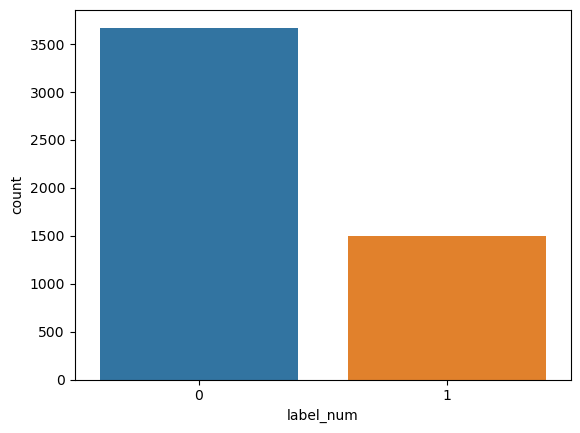

In [8]:
sns.countplot(x='label_num', data=data)
plt.show()

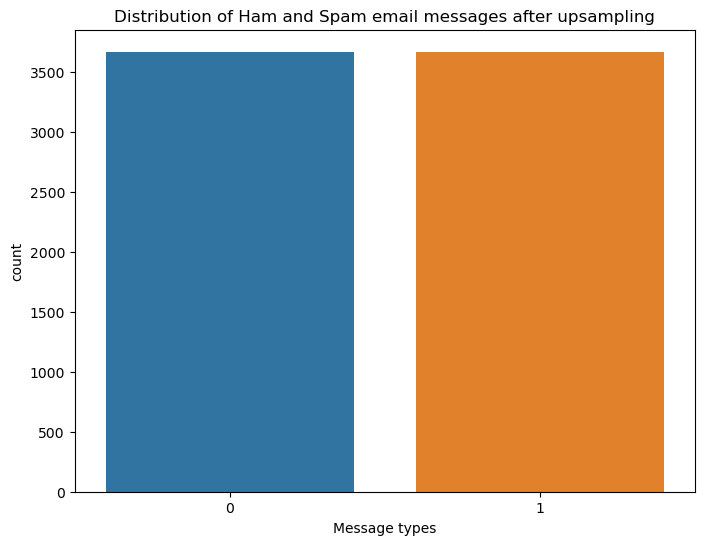

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'label_num' is your column for the spam/ham labels
ham_msg = data[data.label_num == 0]
spam_msg = data[data.label_num == 1]
spam_msg_upsampled = spam_msg.sample(n=len(ham_msg), replace=True, random_state=42)

# Creating a new DataFrame by concatenating the upsampled spam messages to ham messages
balanced_data = pd.concat([ham_msg, spam_msg_upsampled]).reset_index(drop=True)

# Plotting the counts of the upsampled dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_data, x='label_num')
plt.title('Distribution of Ham and Spam email messages after upsampling')
plt.xlabel('Message types')
plt.show()


In [14]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,: enron methanol ; meter # : 988291\r\nthis is...,0
1,2349,ham,": hpl nom for january 9 , 2001\r\n( see attach...",0
2,3624,ham,": neon retreat\r\nho ho ho , we ' re around to...",0
3,2030,ham,: re : indian springs\r\nthis deal is to book ...,0
4,2949,ham,: ehronline web address change\r\nthis message...,0


In [15]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,enron methanol meter 988291\r\nthis is a f...,0
1,2349,ham,hpl nom for january 9 2001\r\n see attached ...,0
2,3624,ham,neon retreat\r\nho ho ho we re around to th...,0
3,2030,ham,re indian springs\r\nthis deal is to book th...,0
4,2949,ham,ehronline web address change\r\nthis message ...,0


In [16]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,enron methanol meter 988291 follow note gave m...,0
1,2349,ham,hpl nom january 9 2001 see attached file hplno...,0
2,3624,ham,neon retreat ho ho ho around wonderful time ye...,0
3,2030,ham,indian springs deal book teco pvr revenue unde...,0
4,2949,ham,ehronline web address change message intended ...,0


In [18]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['label_num'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [19]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')

In [20]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1464352   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1468065 (5.60 MB)
Trainable params: 1468065 (5.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [22]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [23]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20, 
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20


184/184 [==============================] - 27s 98ms/step - loss: 0.4076 - accuracy: 0.7908 - val_loss: 0.1529 - val_accuracy: 0.9612 - lr: 0.0010
Epoch 2/20
184/184 [==============================] - 16s 84ms/step - loss: 0.2031 - accuracy: 0.9445 - val_loss: 0.3747 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 3/20
184/184 [==============================] - 14s 78ms/step - loss: 0.3150 - accuracy: 0.8749 - val_loss: 0.2873 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 4/20
184/184 [==============================] - 15s 80ms/step - loss: 0.2622 - accuracy: 0.9033 - val_loss: 0.2805 - val_accuracy: 0.8938 - lr: 5.0000e-04


In [24]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

46/46 [==============================] - 1s 23ms/step - loss: 0.1529 - accuracy: 0.9612
Test Loss : 0.15294602513313293
Test Accuracy : 0.961198091506958


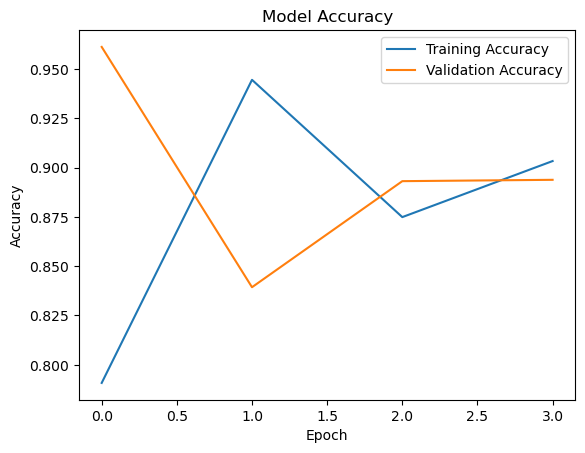

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()